In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV


%matplotlib inline

## The task

The task is to predict item outlet sales based on some features regarding each item such as: item weight, item visibility in the shop, type of the item, maximum retail price of the item, identifier of the outlet where the item is being sold, outlet establishment year, outlet size, outlet location and outlet type. It is therefore a regression problem.

## Load data

There is a train set and test set already provided but test set does not contain any labels. Therefore we gonna preprocess the train set and then split it for test and train. The original test set will be used to make inference in the web app we gonna build later.

In [99]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [37]:
train_data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Preprocessing

There is a lot that can be done with the given data to prepare it for training. Since we want to deploy the model later on to make predictions on the incoming data, this data will also have to be preprocessed. There is no point to make the same operations twice so that we gonna use transfomers for every operation. This is also very convenient way cause once the entire pipeline of transformations is fitted to the training set it can be saved as a pickle file and then used straight away to preprocess the incoming data.

Let's first check data types and if there are any missing values. We should also look for any duplicated values.

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [39]:
train_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [40]:
train_data.duplicated().sum()

0

As we can see, Item_Weight and Outlet_Size are the only features that have missing values so we will have to find the best way to impute them. For this purpose lets plot histograms and estimated distributions for each numerical feature. Boxplots can also tell us a lot about the distributions.

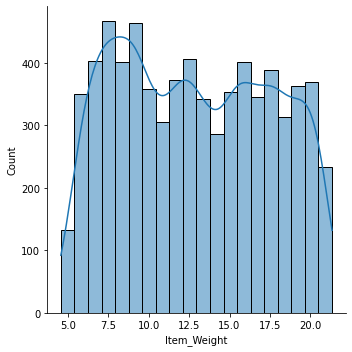

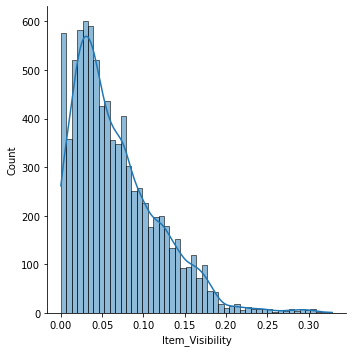

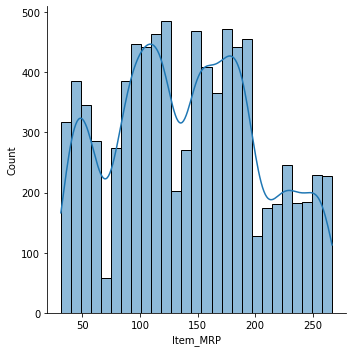

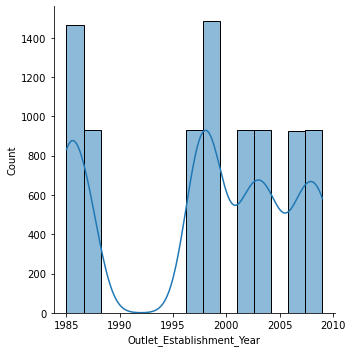

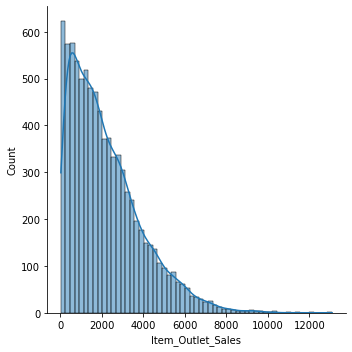

In [41]:
for i in train_data.describe().columns:
    sns.displot(train_data[i], kde=True)

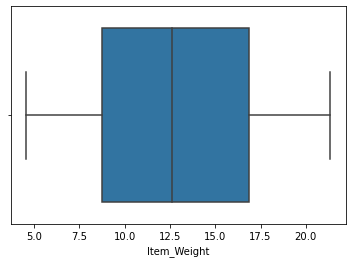

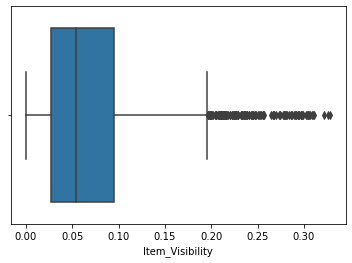

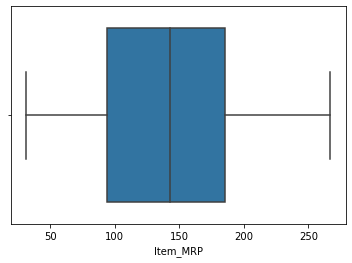

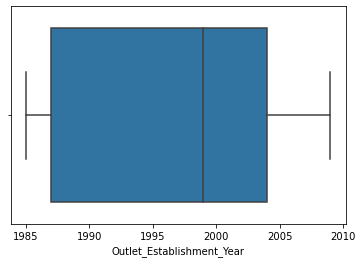

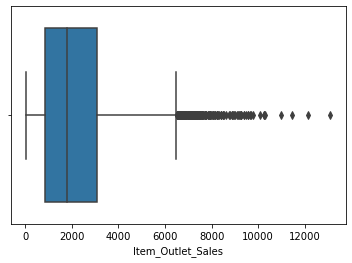

In [42]:
for i in train_data.describe().columns:
    sns.boxplot(x=train_data[i])
    plt.show()

Distribution for Item_Weigth is close to normal so that we can safely impute missing values with a mean. For the Outlet_Size we have to look at the unique values and their total count cause it is a categorical feature.

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

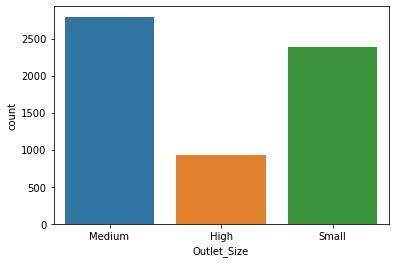

In [43]:
sns.countplot(data=train_data, x=train_data['Outlet_Size'])

For categorical features the best option to impute is to use the most frequent value which is called **mode**. Therefore we should use Medium size here.

There is a built-in transformer that can impute values but since most of our pipeline is custom we can also build it easily.
In the fit function we take the mode and mean values for respective columns in the train set only. Transform function is then used on the train and test sets.

In [44]:
class custom_imputer(BaseEstimator, TransformerMixin):
    def __init_(self):
        self.mode_to_replace = None
        self.mean_to_replace = None
    
    def fit(self, X, y=None):
        X_new = X.copy()
        self.mode_to_replace = X_new['Outlet_Size'].mode()[0]
        self.mean_to_replace = X_new['Item_Weight'].mean()
        
        return self
    
    def transform(self, X, y=None):
        X_new = X.copy()
        X_new['Outlet_Size'].fillna(self.mode_to_replace, inplace=True)
        X_new['Item_Weight'].fillna(self.mean_to_replace, inplace=True)
        
        return X_new

From the boxplots shown above we can also infer that there are many outliers in the Item_Visibility feature. We can either remove them or replace with some value. Since they come from skewed distribution we should only replace them with the median, not the mean. Outliers are filtered using the so called **Interquartile range** which is defined by the difference between the 3rd and 1st quantile. Then we discard the values which are below **Q1 - factor * IQR** and above **Q3 + factor * IQR**. Factor controls the amount of removed or replaced outliers. We define the small function below which does this. Then it can be passed to the FunctionTransfomer which creates an sklearn transformer from a function. We gonna use this transfomer on the entire dataset so here we do not have to distinguish between the actions taken in the fit and transform functions separately.

In [45]:
def outlier_removal(X, col, factor, drop=False):
    X_new = X.copy()
    Q1 = X_new[col].quantile(0.25)
    Q3 = X_new[col].quantile(0.75)
    IQR = Q3 - Q1
    if drop:
        X_new.loc[(X_new[col] < Q1 - factor * IQR) | (X_new[col] > Q3 + factor * IQR), col] = np.nan
        X_new.dropna(axis=0, inplace=True)
    else:
        X_new.loc[(X_new[col] < Q1 - factor * IQR) | (X_new[col] > Q3 + factor * IQR), col] = X_new[col].median()
        
    return X_new

In [46]:
outlier_remover = FunctionTransformer(outlier_removal, kw_args={'col':'Item_Visibility', 'factor':1.5})

Now there are couple of things that can also be done with the categorical features. First of all lets look at the unique values.

In [47]:
train_data.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [48]:
train_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

When we also examine each feature separately we can spot that the Item_Fat_Content has actually only 2 unique values instead of 5. We can easily clean it by replacing with correct categories. Now we can also see that the type content is actually assigned to any item type regardless if it is food or eg. household type item. Additionally we know that the first two letters of the item identifier indicate the type of the item. There are only 3 unique combinations which stand for food, drinks and non-consumable categories. According to this we can create a new feature and categorize every item. Then wherever the item type will be a non-consumable, we will put 'Non-Edible' as an Item_Fat_Content. With a new item type column we can safely drop the original one. Since there is nothing specific to any dataset in these transformations we do not need the separate fit and transform methods. So lets just define a simple function and pass it to the FunctionTransformer as before.

In [49]:
def replace_add_drop_cat(X):
    X_new = X.copy()
    X_new['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)
    
    X_new['New_Item_Type'] = X_new['Item_Identifier'].apply(lambda x: x[:2])
    X_new['New_Item_Type'].replace({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'}, inplace=True)
    X_new.loc[X_new['New_Item_Type'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
    
    X_new.drop('Item_Type', axis=1, inplace=True)
    
    return X_new

Now lets come back to the numerical features. When we look at the distribution of the Item_Visibility feature we can easily spot that there are a lot of entries with 0 visibility. This obviously cannot happen cause it will mean that item is not present in the shop. Therefore we can assume that zeros are the NaN values and they are missing. We have to replace them with NaN values and impute with median as the distribution is highly skewed. What also can be done is to convert the Outlet_Establishment_Year to the age of the specific outlet with respect to the newest outlet. We have to remember that both median and max year has to be taken from the train data only in the fit function. 

In our dataset for every item identifier we can find couple of entries. They correspond to the same item but in different outlets. We can also see that the item visibility is different in each outlet.

In [50]:
train_data[train_data['Item_Identifier'] == 'FDA15']['Item_Visibility']

0       0.016047
831     0.016055
2599    0.016019
2643    0.016088
4874    0.026818
5413    0.016009
6696    0.015945
7543    0.016113
Name: Item_Visibility, dtype: float64

Therefore it is a good idea to create a new feature which will be the ratio of the item visibility for an item in a single outlet to the average visibility for that item in all of the outlets. Average visibility for each identifier is calculated on the train data and then used to create new feature on the test and train data. At the end we can also drop the Item_Identifier feature cause it won't be useful anymore. All of the above-mentioned transformations are done in a single transformer defined below.

In [51]:
class replace_add_drop_num(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.median_to_replace = None
        self.max_year = None
        self.item_visib_avg = None
        self.avg = None
        self.unique_name = None
        self.mapper = None
        
    def fit(self, X, y=None):
        # only on the training set
        X_new = X.copy()
        
        # replace 0 with nan and then median
        X_new.loc[X_new['Item_Visibility'] == 0, 'Item_Visibility'] = np.nan
        self.median_to_replace = X_new['Item_Visibility'].median()
        X_new['Item_Visibility'].fillna(self.median_to_replace, inplace=True)
        
        
        # get the max year
        self.max_year = X_new['Outlet_Establishment_Year'].max()
        
        # get the list of average item visibilities for each identifier and 
        # create dictionary to map this value to the corresponding identifier
        self.avg = [X_new[X_new['Item_Identifier']==item]['Item_Visibility'].mean() for item in X_new['Item_Identifier'].unique()]
        self.unique_name = X_new['Item_Identifier'].unique()
        self.mapper = dict(zip(self.unique_name, self.avg))

        return self
    
    def transform(self, X, y=None):
        X_new = X.copy()
        
        X_new['Item_Visibility'].replace({0: self.median_to_replace}, inplace=True)
        
        X_new['Outlet_Establishment_Year'] = self.max_year - X_new['Outlet_Establishment_Year']
        
        X_new['item_visible_avg'] = X_new['Item_Visibility']
        for name, item in self.mapper.items():
            X_new.loc[X_new['Item_Identifier'] == name, 'item_visible_avg'] /= item
        
        X_new.drop('Item_Identifier', axis=1, inplace=True)
        
        return X_new

Before we proceed to the training we also have to scale the numerical features and convert categorical features to the one hot vectors. This can be easily done using ColumnTransformer and specifying columns on which the transformer should be applied. The final step is to merge the custom transfomers with the ColumnTransformer into a single preprocessing pipeline. All this is done below.

In [52]:
one_hot_cols = ['New_Item_Type', 'Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size',
                'Outlet_Location_Type', 'Outlet_Type']
scale_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'item_visible_avg']

col_trans_pipe = ColumnTransformer([
    ('scale', StandardScaler(), scale_cols),
    ('one_hot', OneHotEncoder(), one_hot_cols)
])

prep_pipe_full = Pipeline([
    ('custom_imputer', custom_imputer()),
    ('replace_add_drop_cat', FunctionTransformer(replace_add_drop_cat)),
    ('replace_add_drop_num', replace_add_drop_num()),
    ('col_trans_pipe', col_trans_pipe)
])

Before training we have to remove outliers and also split the data. Then we can fit our pipeline on the train set and transform our test set with it.

In [53]:
train_data_no_out = outlier_remover.fit_transform(train_data)

In [54]:
X = train_data_no_out.drop('Item_Outlet_Sales', axis=1)
y = train_data_no_out['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120)

In [55]:
X_train = prep_pipe_full.fit_transform(X_train)

In [56]:
X_train.shape

(6818, 31)

In [57]:
X_test = prep_pipe_full.transform(X_test)

In [58]:
X_test.shape

(1705, 31)

Now we can simply save it and then reuse in the application for the incoming data.

In [59]:
pickle.dump(prep_pipe_full, open('prep_pipe_full.pkl', 'wb'))

## Training

We can start training by checking couple of base models and look at their relative performance. As a metrics we will use the **r2 score**, **MSE** and **MAE**. 

In [84]:
models = {
    'lr': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'rf': RandomForestRegressor(n_jobs=-1),
    'knr': KNeighborsRegressor(n_jobs=-1),
    'svr': SVR(kernel='linear'),
    'xgb': XGBRegressor(n_jobs=-1),
    'cat': CatBoostRegressor(),
    'extra': ExtraTreesRegressor(n_jobs=-1)
}

trained_models = {}

for name, algo in models.items():
    model = algo.fit(X_train, y_train)
    trained_models[name] = model

Learning rate set to 0.054928
0:	learn: 1646.2614193	total: 171ms	remaining: 2m 50s
1:	learn: 1599.7644258	total: 183ms	remaining: 1m 31s
2:	learn: 1556.6323464	total: 193ms	remaining: 1m 4s
3:	learn: 1515.4302607	total: 204ms	remaining: 50.7s
4:	learn: 1478.3534276	total: 212ms	remaining: 42.1s
5:	learn: 1444.9014712	total: 218ms	remaining: 36.2s
6:	learn: 1416.6260315	total: 222ms	remaining: 31.5s
7:	learn: 1386.6342522	total: 225ms	remaining: 27.9s
8:	learn: 1358.4112951	total: 229ms	remaining: 25.2s
9:	learn: 1332.4424637	total: 232ms	remaining: 22.9s
10:	learn: 1308.4197158	total: 235ms	remaining: 21.1s
11:	learn: 1288.6548905	total: 238ms	remaining: 19.6s
12:	learn: 1269.4753896	total: 241ms	remaining: 18.3s
13:	learn: 1251.0349584	total: 243ms	remaining: 17.1s
14:	learn: 1235.3348946	total: 246ms	remaining: 16.1s
15:	learn: 1220.4786867	total: 248ms	remaining: 15.2s
16:	learn: 1207.2704225	total: 249ms	remaining: 14.4s
17:	learn: 1195.4637157	total: 251ms	remaining: 13.7s
18:	le

168:	learn: 1018.2834545	total: 508ms	remaining: 2.5s
169:	learn: 1017.9178600	total: 509ms	remaining: 2.49s
170:	learn: 1017.6465086	total: 511ms	remaining: 2.48s
171:	learn: 1017.2115701	total: 513ms	remaining: 2.47s
172:	learn: 1016.9348772	total: 514ms	remaining: 2.46s
173:	learn: 1016.6581958	total: 516ms	remaining: 2.45s
174:	learn: 1016.3038523	total: 518ms	remaining: 2.44s
175:	learn: 1015.9039038	total: 521ms	remaining: 2.44s
176:	learn: 1015.6021787	total: 523ms	remaining: 2.43s
177:	learn: 1015.3334252	total: 525ms	remaining: 2.42s
178:	learn: 1014.9427088	total: 526ms	remaining: 2.41s
179:	learn: 1014.5665735	total: 528ms	remaining: 2.4s
180:	learn: 1014.4486525	total: 530ms	remaining: 2.4s
181:	learn: 1014.0834034	total: 532ms	remaining: 2.39s
182:	learn: 1013.5794171	total: 533ms	remaining: 2.38s
183:	learn: 1013.3056738	total: 535ms	remaining: 2.37s
184:	learn: 1012.8985669	total: 537ms	remaining: 2.36s
185:	learn: 1012.5479559	total: 538ms	remaining: 2.35s
186:	learn: 1

382:	learn: 952.4534717	total: 844ms	remaining: 1.36s
383:	learn: 952.0571194	total: 846ms	remaining: 1.36s
384:	learn: 951.8573708	total: 848ms	remaining: 1.35s
385:	learn: 951.5754592	total: 850ms	remaining: 1.35s
386:	learn: 951.3053581	total: 852ms	remaining: 1.35s
387:	learn: 951.1190595	total: 853ms	remaining: 1.35s
388:	learn: 950.8698260	total: 856ms	remaining: 1.34s
389:	learn: 950.6592912	total: 858ms	remaining: 1.34s
390:	learn: 950.5279989	total: 860ms	remaining: 1.34s
391:	learn: 950.3185103	total: 862ms	remaining: 1.34s
392:	learn: 950.1638766	total: 864ms	remaining: 1.33s
393:	learn: 949.9445854	total: 866ms	remaining: 1.33s
394:	learn: 949.6070909	total: 868ms	remaining: 1.33s
395:	learn: 949.2450984	total: 870ms	remaining: 1.33s
396:	learn: 949.1274844	total: 871ms	remaining: 1.32s
397:	learn: 948.7750637	total: 873ms	remaining: 1.32s
398:	learn: 948.5778124	total: 874ms	remaining: 1.32s
399:	learn: 948.4379115	total: 877ms	remaining: 1.31s
400:	learn: 948.1356610	tota

585:	learn: 901.5668220	total: 1.18s	remaining: 830ms
586:	learn: 901.2486774	total: 1.18s	remaining: 828ms
587:	learn: 900.8179351	total: 1.18s	remaining: 826ms
588:	learn: 900.5908920	total: 1.18s	remaining: 824ms
589:	learn: 900.3596513	total: 1.18s	remaining: 822ms
590:	learn: 900.0825665	total: 1.18s	remaining: 820ms
591:	learn: 899.8974224	total: 1.19s	remaining: 818ms
592:	learn: 899.6689163	total: 1.19s	remaining: 816ms
593:	learn: 899.5081500	total: 1.19s	remaining: 814ms
594:	learn: 899.2917740	total: 1.19s	remaining: 812ms
595:	learn: 899.0805187	total: 1.19s	remaining: 810ms
596:	learn: 898.8524326	total: 1.2s	remaining: 807ms
597:	learn: 898.6454984	total: 1.2s	remaining: 805ms
598:	learn: 898.4596787	total: 1.2s	remaining: 803ms
599:	learn: 898.1369262	total: 1.2s	remaining: 801ms
600:	learn: 897.8819585	total: 1.2s	remaining: 799ms
601:	learn: 897.5474303	total: 1.2s	remaining: 796ms
602:	learn: 897.4074936	total: 1.21s	remaining: 794ms
603:	learn: 897.1798346	total: 1.2

779:	learn: 861.8693813	total: 1.51s	remaining: 425ms
780:	learn: 861.6751795	total: 1.51s	remaining: 424ms
781:	learn: 861.6509660	total: 1.51s	remaining: 422ms
782:	learn: 861.4430785	total: 1.51s	remaining: 420ms
783:	learn: 861.2413193	total: 1.52s	remaining: 418ms
784:	learn: 861.2185199	total: 1.52s	remaining: 416ms
785:	learn: 861.0108730	total: 1.52s	remaining: 414ms
786:	learn: 860.8128255	total: 1.52s	remaining: 412ms
787:	learn: 860.7633337	total: 1.52s	remaining: 410ms
788:	learn: 860.5881343	total: 1.53s	remaining: 408ms
789:	learn: 860.5382528	total: 1.53s	remaining: 407ms
790:	learn: 860.4766847	total: 1.53s	remaining: 405ms
791:	learn: 860.2759574	total: 1.53s	remaining: 403ms
792:	learn: 859.8537548	total: 1.53s	remaining: 401ms
793:	learn: 859.8311711	total: 1.54s	remaining: 399ms
794:	learn: 859.8195850	total: 1.54s	remaining: 397ms
795:	learn: 859.6141179	total: 1.54s	remaining: 395ms
796:	learn: 859.3856013	total: 1.54s	remaining: 393ms
797:	learn: 859.0870197	tota

950:	learn: 831.9396064	total: 1.84s	remaining: 94.6ms
951:	learn: 831.6579968	total: 1.84s	remaining: 92.7ms
952:	learn: 831.4591159	total: 1.84s	remaining: 90.8ms
953:	learn: 831.2081043	total: 1.84s	remaining: 88.8ms
954:	learn: 831.1312278	total: 1.84s	remaining: 86.9ms
955:	learn: 830.9805163	total: 1.84s	remaining: 84.9ms
956:	learn: 830.6886398	total: 1.85s	remaining: 83ms
957:	learn: 830.5988245	total: 1.85s	remaining: 81.1ms
958:	learn: 830.3992712	total: 1.85s	remaining: 79.2ms
959:	learn: 830.2615135	total: 1.85s	remaining: 77.2ms
960:	learn: 830.1355702	total: 1.85s	remaining: 75.3ms
961:	learn: 829.9483074	total: 1.86s	remaining: 73.3ms
962:	learn: 829.7659238	total: 1.86s	remaining: 71.4ms
963:	learn: 829.5014179	total: 1.86s	remaining: 69.5ms
964:	learn: 829.3799258	total: 1.86s	remaining: 67.5ms
965:	learn: 829.2249308	total: 1.86s	remaining: 65.6ms
966:	learn: 829.0127867	total: 1.86s	remaining: 63.7ms
967:	learn: 828.8991342	total: 1.87s	remaining: 61.7ms
968:	learn: 

In [85]:
r2 = [round(r2_score(y_test, model.predict(X_test)) * 100, 2) for model in list(trained_models.values())]
mse = [round(mean_squared_error(y_test, model.predict(X_test))) for model in list(trained_models.values())]
mae = [round(mean_absolute_error(y_test, model.predict(X_test)), 2) for model in list(trained_models.values())]
names = [name for name in list(trained_models.keys())]
base_model_performance = {'r2':r2, 'mse':mse, 'mae':mae}
base_model_performance = pd.DataFrame(base_model_performance, index=names)

In [86]:
base_model_performance

,r2,mse,mae
lr,56.47,1326371,850.10
ridge,56.46,1326451,849.56
lasso,56.45,1326860,849.68
rf,55.53,1354882,822.23
knr,49.63,1534551,876.88
svr,43.90,1709235,928.92
xgb,54.56,1384387,837.11
cat,57.21,1303666,797.90
extra,52.87,1435889,844.19


It looks like even linear models are doing quite well and are comparable to the catboost or random forest. R2 score at this level is acceptable but we would like to achieve the best performance so we have to tune the best models. Just to compare lets see how the models are doing on the train data.

In [87]:
r2_train = [round(r2_score(y_train, model.predict(X_train)) * 100, 2) for model in list(trained_models.values())]
mse_train = [round(mean_squared_error(y_train, model.predict(X_train))) for model in list(trained_models.values())]
mae_train = [round(mean_absolute_error(y_train, model.predict(X_train)), 2) for model in list(trained_models.values())]
names = [name for name in list(trained_models.keys())]
base_model_performance_train = {'r2':r2_train, 'mse':mse_train, 'mae':mae_train}
base_model_performance_train = pd.DataFrame(base_model_performance_train, index=names)

In [88]:
base_model_performance_train

,r2,mse,mae
lr,56.19,1258489,830.78
ridge,56.21,1257935,830.60
lasso,56.21,1258030,830.19
rf,93.80,178209,290.46
knr,67.19,942561,681.53
svr,46.50,1536866,874.82
xgb,85.29,422450,465.43
cat,76.35,679404,592.88
extra,100.00,0,0.00


Now we can see that linear models are actually not overfitting and cannot do better but random forest, xgb, catboost and extratrees are highly overfitting the training set. Lets try fine tuning the best models.

## Random Forest tuning

In [62]:
param_grid = {
    'n_estimators': list(range(1000)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': list(range(30)),
    'min_samples_split': list(range(30)),
    'min_samples_leaf': list(range(20))
}

rf_search = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=5, n_iter=500, n_jobs=-1, random_state=120, verbose=2)
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.57299679 0.56116689 0.56065997 0.5957482  0.57665714 0.58743149
 0.576183   0.46052476 0.56044042        nan 0.57162339 0.48540829
 0.48699666        nan 0.55004163 0.57271622 0.59167921        nan
 0.59015282 0.5767276  0.24203945        nan 0.58979079 0.56790158
 0.58988478 0.59048071 0.58662262 0.55737346 0.56306809        nan
 0.54750749        nan        nan 0.58882288 0.53434097 0.58580134
        nan 0.53711272        nan        nan 0.57547239 0.57248891
 0.57308669 0.59063317 0.5896931  0.53825535 0.58843588 0.49048358
        nan 0.5153655  0.58759395 0.54653078        nan 0.59216347
 0.5486308         nan 0.58656528        nan 0.55885732 0.56849249
 0.59035952 0.57234298        nan 0.36776968 0.56256794 0.55196232
 0.59050831 0.5752974  0.18168334 0.56353528 0.57005283        nan
 0.54846834 0.58780616 0.58759153        nan 0.540615

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [0, 1, 2, 3, 4, 5,
                                                             6, 7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19],
                                        'min_samples_split': [0

In [63]:
rf_search.best_params_

{'n_estimators': 50,
 'min_samples_split': 16,
 'min_samples_leaf': 16,
 'max_features': 'auto',
 'max_depth': 5}

In [64]:
pickle.dump(rf_search, open('rf_tuned.pkl', 'wb'))
rf_search = pickle.load(open('rf_tuned.pkl', 'rb'))
y_pred = rf_search.predict(X_test)
print('rf_tuned', round(100 * r2_score(y_test, y_pred), 2), 
          round(mean_absolute_error(y_test, y_pred), 2),
         round(mean_squared_error(y_test, y_pred)))

rf_tuned 59.75 782.1 1226353


## CatBoost tuning

In [ ]:
param_grid= {'depth': list(range(10)),
            'learning_rate': np.power(10, np.arange(-5., 0.)),
            'iterations': list(range(1000)),
             'l2_leaf_reg': list(range(400)),
             'random_strength': list(range(10)),
             'bagging_temperature': list(range(10)),
}

cat_search = RandomizedSearchCV(CatBoostRegressor(), param_grid, n_iter=500, cv=5, verbose=2, n_jobs=-1)
cat_search.fit(X_train, y_train)

In [ ]:
cat_search.best_params_

In [65]:
pickle.dump(cat_search, open('cat_tuned.pkl', 'wb'))
cat_search = pickle.load(open('cat_tuned.pkl', 'rb'))
y_pred = cat_search.predict(X_test)
print('cat_tuned', round(100 * r2_score(y_test, y_pred), 2), 
          round(mean_absolute_error(y_test, y_pred), 2),
         round(mean_squared_error(y_test, y_pred)))

cat_tuned 60.46 770.98 1204717


## XGB tuning

In [ ]:
from hpsklearn import HyperoptEstimator, xgboost_regression
from hyperopt import tpe


estim = HyperoptEstimator(regressor=xgboost_regression('my_xgb'),preprocessing=[],
                          algo=tpe.suggest, max_evals=50, trial_timeout=300)

estim.fit(X_train, y_train)

In [ ]:
estim.best_model()['learner']

In [67]:
pickle.dump(estim.best_model()['learner'], open('xgb_tuned.pkl', 'wb'))
xgb_tuned = pickle.load(open('xgb_tuned.pkl', 'rb'))
y_pred = xgb_tuned.predict(X_test)
print('cat_tuned', round(100 * r2_score(y_test, y_pred), 2), 
          round(mean_absolute_error(y_test, y_pred), 2),
         round(mean_squared_error(y_test, y_pred)))

cat_tuned 60.08 778.18 1216324


Now lets compare the performance of the fine tuned models on the test and train set.

In [68]:
fine_tuned_models = {'rf':rf_search, 'catboost':cat_search, 'xgb': xgb_tuned}
r2_tuned = [round(r2_score(y_test, model.predict(X_test)) * 100, 2) for model in list(fine_tuned_models.values())]
mse_tuned = [round(mean_squared_error(y_test, model.predict(X_test))) for model in list(fine_tuned_models.values())]
mae_tuned = [round(mean_absolute_error(y_test, model.predict(X_test)), 2) for model in list(fine_tuned_models.values())]
names = [name for name in list(fine_tuned_models.keys())]
tuned_model_performance = {'r2':r2_tuned, 'mse':mse_tuned, 'mae':mae_tuned}
tuned_model_performance = pd.DataFrame(tuned_model_performance, index=names)

In [69]:
tuned_model_performance

,r2,mse,mae
rf,59.75,1226353,782.10
catboost,60.46,1204717,770.98
xgb,60.08,1216324,778.18


In [70]:
r2_tuned_train = [round(r2_score(y_train, model.predict(X_train)) * 100, 2) for model in list(fine_tuned_models.values())]
mse_tuned_train = [round(mean_squared_error(y_train, model.predict(X_train))) for model in list(fine_tuned_models.values())]
mae_tuned_train = [round(mean_absolute_error(y_train, model.predict(X_train)), 2) for model in list(fine_tuned_models.values())]
names = [name for name in list(fine_tuned_models.keys())]
tuned_model_performance_train = {'r2':r2_tuned_train, 'mse':mse_tuned_train, 'mae':mae_tuned_train}
tuned_model_performance_train = pd.DataFrame(tuned_model_performance_train, index=names)

In [71]:
tuned_model_performance_train

,r2,mse,mae
rf,60.89,1123504,740.63
catboost,61.05,1118953,741.63
xgb,62.79,1069022,728.01


After fine tuning the best models we dont have any overfitting and scores on both train and test set are very similar. The increase in performance is very small with comparison to the base models but we cannot do better.

All three of our fine tuned models can be used to estimate feature importances. Lets do this and compare with the correlation matrix. Function below is defined just to be able to extract feature names from the ColumnTransformer and assign to the estimated importances.

In [72]:
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

<ipython-input-72-40d3bafd709a>:32: UserWarning: Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


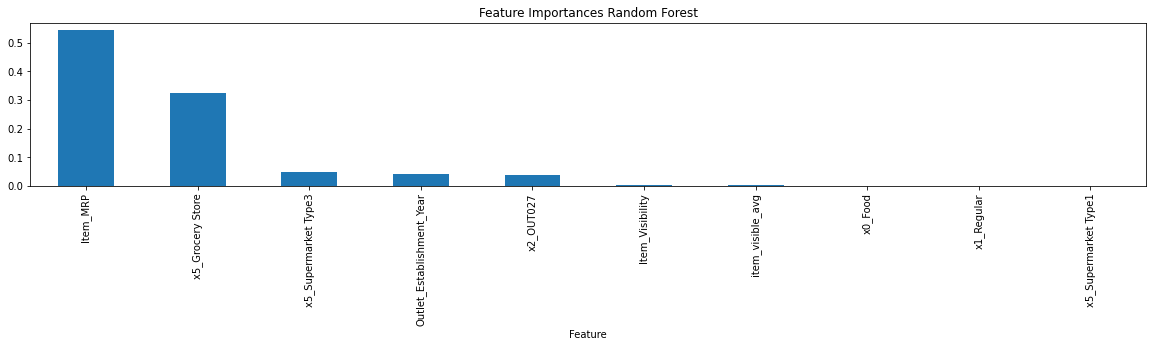

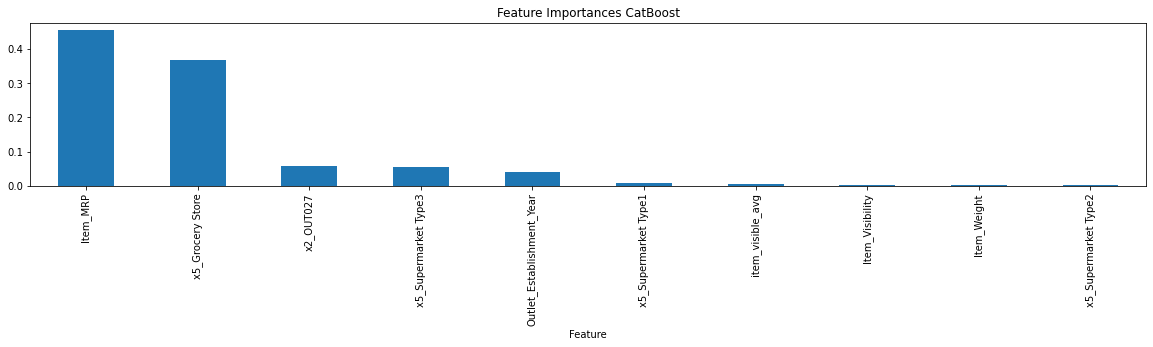

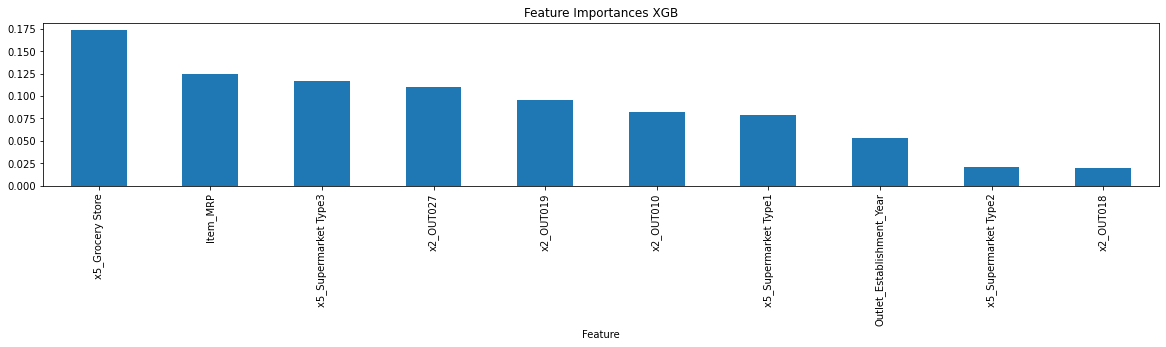

In [73]:
importances = pd.DataFrame({
    'Feature': get_feature_names(col_trans_pipe),
    'Importance_RF': rf_search.best_estimator_.feature_importances_ ,
    'Importance_CatBoost': cat_search.best_estimator_.feature_importances_ / 100,
    'Importance_XGB': xgb_tuned.feature_importances_
})
importances = importances.set_index('Feature')

importances['Importance_RF'].sort_values(ascending=False)[:10].plot(kind='bar', 
                                            figsize=(20,3), title='Feature Importances Random Forest')
plt.show()
importances['Importance_CatBoost'].sort_values(ascending=False)[:10].plot(kind='bar', 
                                            figsize=(20,3), title='Feature Importances CatBoost')
plt.show()
importances['Importance_XGB'].sort_values(ascending=False)[:10].plot(kind='bar', 
                                            figsize=(20,3), title='Feature Importances XGB')
plt.show()

<AxesSubplot:>

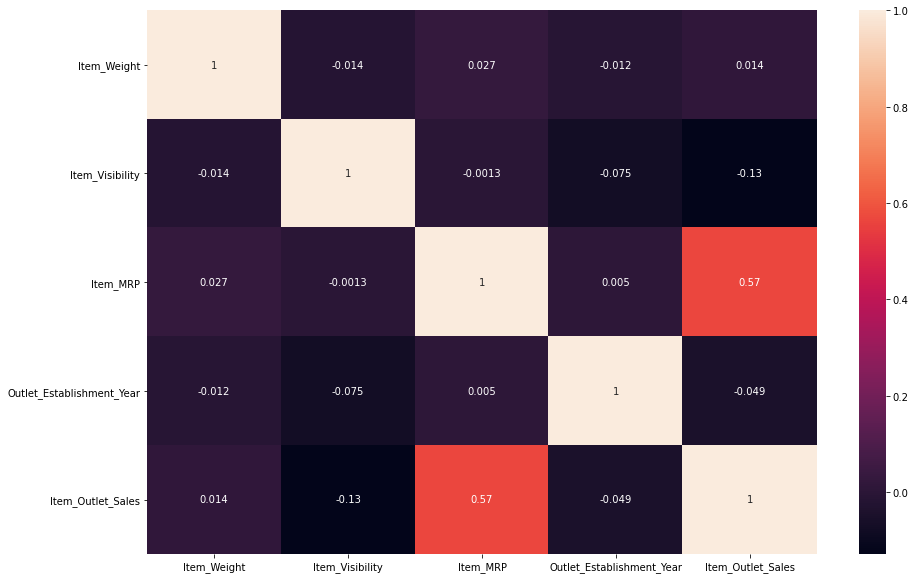

In [74]:
plt.figure(figsize=(15,10))
sns.heatmap(train_data.corr(), annot=True)

Both Random Forest and CatBoost estimated similar features. Maximum retail price is the most important one and we can also see it in the correlation map from the original dataset. XGB shows something different and MRP is at the 2nd position but nevertheless first two most important features are overlapping in all of the models. Before starting deployment lets also test a simple neural network.

In [80]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(120)
np.random.seed(120)
    
checkpoint_cb = keras.callbacks.ModelCheckpoint('nn_model.h5', monitor='mse', save_best_only=True)

model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                           epochs=250, batch_size=32, callbacks=[checkpoint_cb])

Epoch 1/250
214/214 [==============================] - 1s 2ms/step - loss: 7513181.1581 - mse: 7513181.1581 - val_loss: 7156498.0000 - val_mse: 7156498.0000
Epoch 2/250
214/214 [==============================] - 0s 899us/step - loss: 5240430.5605 - mse: 5240430.5605 - val_loss: 2601390.2500 - val_mse: 2601390.2500
Epoch 3/250
214/214 [==============================] - 0s 885us/step - loss: 1996584.6134 - mse: 1996584.6134 - val_loss: 1837487.1250 - val_mse: 1837487.1250
Epoch 4/250
214/214 [==============================] - 0s 889us/step - loss: 1727265.0645 - mse: 1727265.0645 - val_loss: 1616539.3750 - val_mse: 1616539.3750
Epoch 5/250
214/214 [==============================] - 0s 888us/step - loss: 1552906.9401 - mse: 1552906.9401 - val_loss: 1455247.7500 - val_mse: 1455247.7500
Epoch 6/250
214/214 [==============================] - 0s 926us/step - loss: 1458743.9843 - mse: 1458743.9843 - val_loss: 1378557.1250 - val_mse: 1378557.1250
Epoch 7/250
214/214 [===========================

214/214 [==============================] - 0s 900us/step - loss: 1308992.9744 - mse: 1308992.9744 - val_loss: 1238157.5000 - val_mse: 1238157.5000
Epoch 53/250
214/214 [==============================] - 0s 888us/step - loss: 1212392.8802 - mse: 1212392.8802 - val_loss: 1236593.8750 - val_mse: 1236593.8750
Epoch 54/250
214/214 [==============================] - 0s 929us/step - loss: 1226612.8828 - mse: 1226612.8828 - val_loss: 1244618.3750 - val_mse: 1244618.3750
Epoch 55/250
214/214 [==============================] - 0s 908us/step - loss: 1232481.7465 - mse: 1232481.7465 - val_loss: 1235713.7500 - val_mse: 1235713.7500
Epoch 56/250
214/214 [==============================] - 0s 914us/step - loss: 1217569.9913 - mse: 1217569.9913 - val_loss: 1246562.6250 - val_mse: 1246562.6250
Epoch 57/250
214/214 [==============================] - 0s 886us/step - loss: 1254417.0270 - mse: 1254417.0270 - val_loss: 1240814.7500 - val_mse: 1240814.7500
Epoch 58/250
214/214 [==============================]

214/214 [==============================] - 0s 972us/step - loss: 1227451.7110 - mse: 1227451.7110 - val_loss: 1226704.3750 - val_mse: 1226704.3750
Epoch 104/250
214/214 [==============================] - 0s 953us/step - loss: 1237095.0919 - mse: 1237095.0919 - val_loss: 1236488.0000 - val_mse: 1236488.0000
Epoch 105/250
214/214 [==============================] - 0s 934us/step - loss: 1233658.7020 - mse: 1233658.7020 - val_loss: 1237803.8750 - val_mse: 1237803.8750
Epoch 106/250
214/214 [==============================] - 0s 972us/step - loss: 1215783.8151 - mse: 1215783.8151 - val_loss: 1230785.1250 - val_mse: 1230785.1250
Epoch 107/250
214/214 [==============================] - 0s 873us/step - loss: 1223046.3395 - mse: 1223046.3395 - val_loss: 1238573.2500 - val_mse: 1238573.2500
Epoch 108/250
214/214 [==============================] - 0s 881us/step - loss: 1239281.2657 - mse: 1239281.2657 - val_loss: 1235092.3750 - val_mse: 1235092.3750
Epoch 109/250
214/214 [=========================

Epoch 154/250
214/214 [==============================] - 0s 940us/step - loss: 1261267.5715 - mse: 1261267.5715 - val_loss: 1222546.0000 - val_mse: 1222546.0000
Epoch 155/250
214/214 [==============================] - 0s 893us/step - loss: 1216543.4430 - mse: 1216543.4430 - val_loss: 1217536.2500 - val_mse: 1217536.2500
Epoch 156/250
214/214 [==============================] - 0s 909us/step - loss: 1227477.8826 - mse: 1227477.8826 - val_loss: 1219499.5000 - val_mse: 1219499.5000
Epoch 157/250
214/214 [==============================] - 0s 896us/step - loss: 1207300.6637 - mse: 1207300.6637 - val_loss: 1236526.3750 - val_mse: 1236526.3750
Epoch 158/250
214/214 [==============================] - 0s 912us/step - loss: 1228353.3221 - mse: 1228353.3221 - val_loss: 1237334.7500 - val_mse: 1237334.7500
Epoch 159/250
214/214 [==============================] - 0s 883us/step - loss: 1223112.4901 - mse: 1223112.4901 - val_loss: 1224988.1250 - val_mse: 1224988.1250
Epoch 160/250
214/214 [===========

Epoch 205/250
214/214 [==============================] - 0s 897us/step - loss: 1212766.9744 - mse: 1212766.9744 - val_loss: 1228794.1250 - val_mse: 1228794.1250
Epoch 206/250
214/214 [==============================] - 0s 916us/step - loss: 1232703.5797 - mse: 1232703.5797 - val_loss: 1231307.8750 - val_mse: 1231307.8750
Epoch 207/250
214/214 [==============================] - 0s 916us/step - loss: 1289238.7099 - mse: 1289238.7099 - val_loss: 1229689.0000 - val_mse: 1229689.0000
Epoch 208/250
214/214 [==============================] - 0s 929us/step - loss: 1236157.1372 - mse: 1236157.1372 - val_loss: 1225989.7500 - val_mse: 1225989.7500
Epoch 209/250
214/214 [==============================] - 0s 906us/step - loss: 1219922.4148 - mse: 1219922.4148 - val_loss: 1224417.0000 - val_mse: 1224417.0000
Epoch 210/250
214/214 [==============================] - 0s 897us/step - loss: 1183920.1256 - mse: 1183920.1256 - val_loss: 1222708.7500 - val_mse: 1222708.7500
Epoch 211/250
214/214 [===========

<AxesSubplot:>

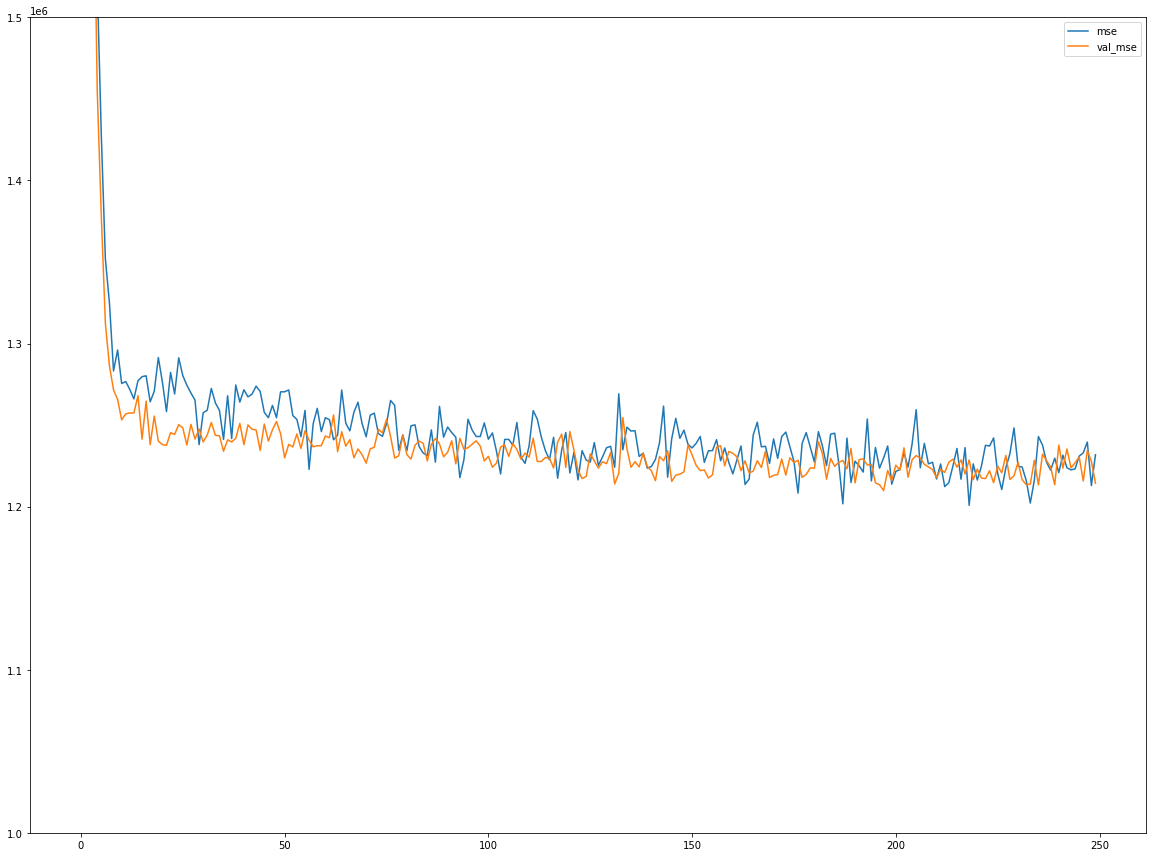

In [81]:
pd.DataFrame({'mse': history.history['mse'], 'val_mse': history.history['val_mse']}).plot(figsize=(20,15), ylim=(1e6, 1.5e6))

In [82]:
final_models = {'rf':rf_search, 'catboost':cat_search, 
                'xgb': xgb_tuned,
               'nn': model}
r2_final = [round(r2_score(y_test, model.predict(X_test)) * 100, 2) for model in list(final_models.values())]
mse_final = [round(mean_squared_error(y_test, model.predict(X_test))) for model in list(final_models.values())]
mae_final = [round(mean_absolute_error(y_test, model.predict(X_test)), 2) for model in list(final_models.values())]
names = [name for name in list(final_models.keys())]
final_model_performance = {'r2':r2_final, 'mse':mse_final, 'mae':mae_final}
final_model_performance = pd.DataFrame(final_model_performance, index=names)

In [83]:
final_model_performance

,r2,mse,mae
rf,59.75,1226353,782.10
catboost,60.46,1204717,770.98
xgb,60.08,1216324,778.18
nn,60.14,1214369,773.94


All models have very similar performance. There is no indication that one is much better then the other. I will use CatBoost for deployment.